Import libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor

In [4]:
from fbprophet import Prophet

In [5]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [6]:
def data_info(table):
    table.info(memory_usage='deep')
    display(table.head(5))

Let's generate features.

In [7]:
def make_features(data,column, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = data.index.year
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    new_data['is_weekend'] = data.index.dayofweek.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = data[column].shift(lag)

    new_data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()
    return new_data

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

 
Graphs.

In [8]:
def plotMovingAverage(y, n):
    plt.figure(figsize=(18,10))
    plt.title("Moving average\n window size = {}".format(n))
    rolling_mean = y.rolling(window=n).mean()
    rolling_std = y.rolling(window=n).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std
    plt.plot(y[n:], label="Actual values")
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.legend(loc="upper left")
    plt.grid(True)
        
def decompose (y, num, figsize=(18, 10)):
    decomposed = seasonal_decompose(y)
    decomposed_1 = seasonal_decompose(y.head(num))
    plt.figure(figsize=figsize)
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed_1.seasonal.plot(ax=plt.gca()) 
    plt.title('Seasonality_begin')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca()) 
    plt.title('Residuals')
    plt.tight_layout()
    
def tsplot(y,n,pvalue, lags=None, figsize=(18, 12), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        rolling_mean = y.rolling(window=n).mean()
        rolling_std = y.rolling(window=n).std()
        upper_bond = rolling_mean+1.96*rolling_std
        lower_bond = rolling_mean-1.96*rolling_std

        ts_ax.plot(y, label="Actual values")
        ts_ax.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        ts_ax.plot(lower_bond, "r--")
        ts_ax.plot(rolling_mean, "g", label="Rolling mean trend")
        ts_ax.set_title('Time Series Analysis Plots')
        ts_ax.legend(loc="upper left")
        smt.graphics.plot_acf(y.values.squeeze(), lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y.values.squeeze(), lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
        print("DF test: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        if (sm.tsa.stattools.adfuller(y)[1] < pvalue):
            print("Timeseries stationary")
        else:
            print("Timeseries non-stationary")
    return

def plot_feature_importance(importance,names,model_type): 
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Data cleaning/transforming

In [9]:
df0 = pd.read_csv('C:/Users/OB/Desktop/projects_to_do/datasets/6_taxi.csv', index_col=[0], parse_dates=[0])
data_info(df0)
print(df0.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


True


In [10]:
df = df0.resample('1H').sum()
data_info(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
df.sort_index(inplace=True)
df = df.dropna()

# Analysis

Let's look trand, seasonal changes and residuals.    

We see slow growing trand. We expect more people order taxi over time.    
Season: evenings/nights, lunchtime. Least popular mornings.

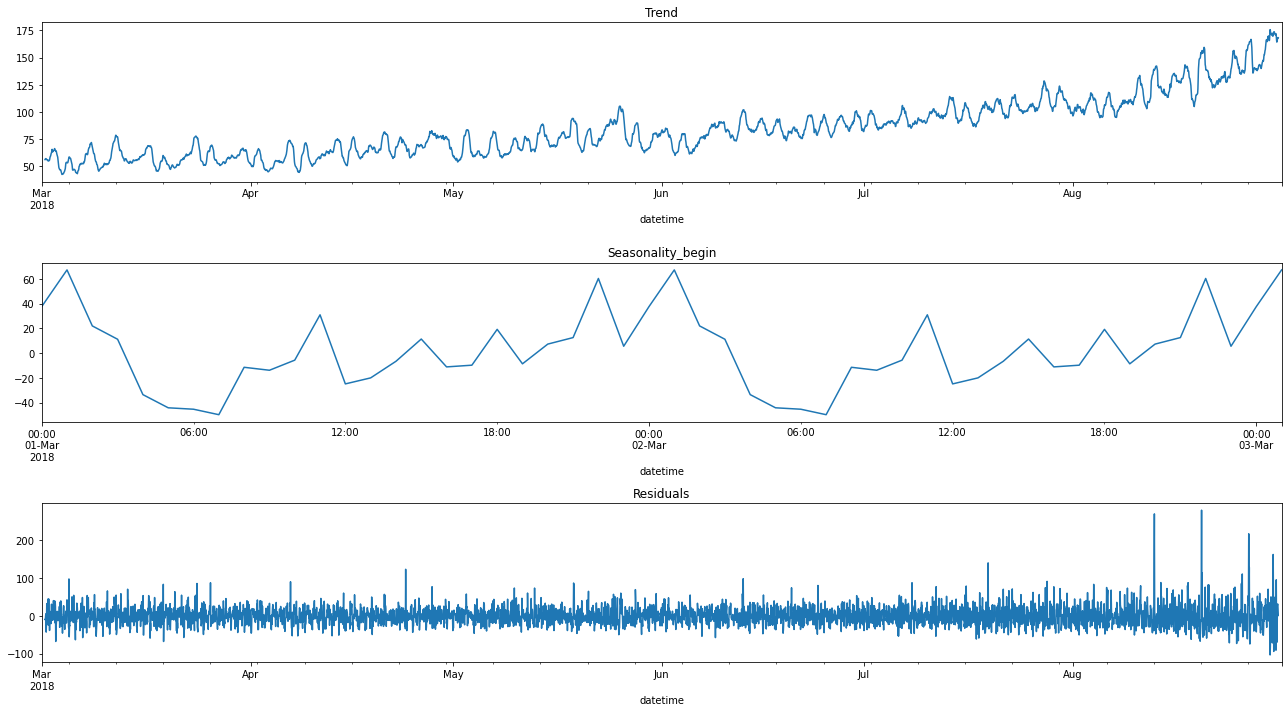

In [12]:
decompose(df['num_orders'], 50)

Let's look on stationarity and rolling mean. Firstly it was not enough stationary. After Box-Cox transformation it gets better.

DF test: p=0.028940
Timeseries non-stationary


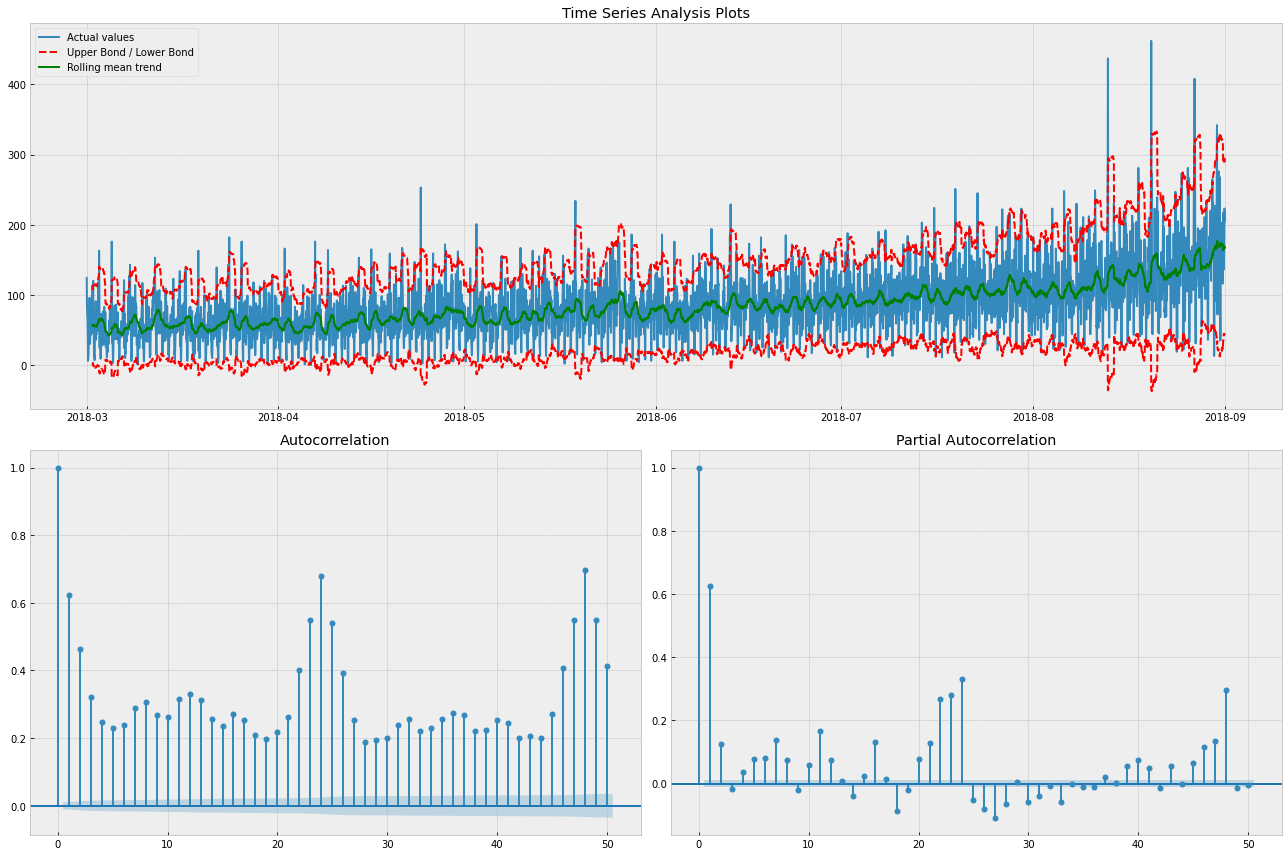

In [13]:
tsplot(df['num_orders'],24, 0.02, lags=50)

DF test: p=0.013676
Timeseries stationary


0.49959816626526066

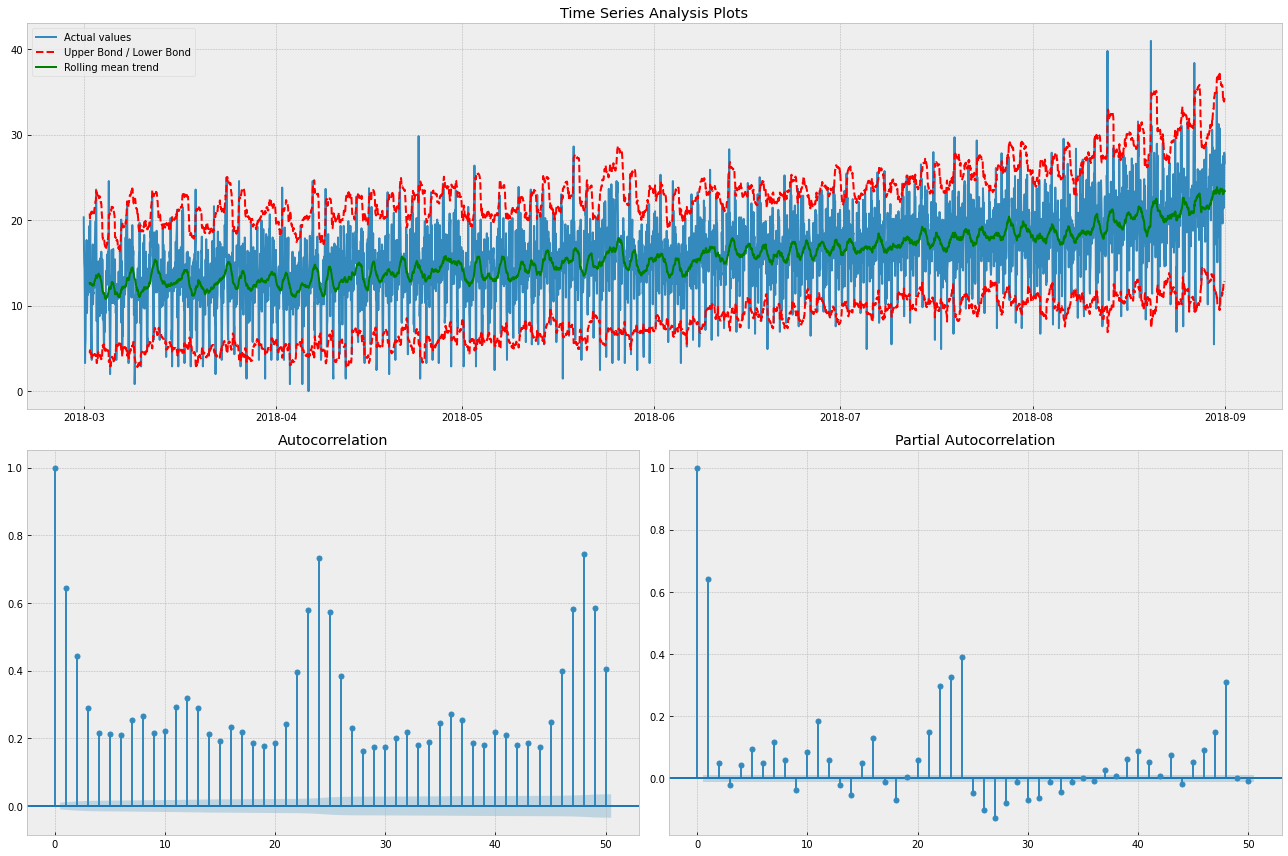

In [14]:
df_cox = df.copy()
df_cox['num_orders_box'], lmbda = scs.boxcox(df_cox['num_orders']+1)
tsplot(df_cox['num_orders_box'],24, 0.02, lags=50)
display(lmbda)

DF test: p=0.000000
Timeseries stationary


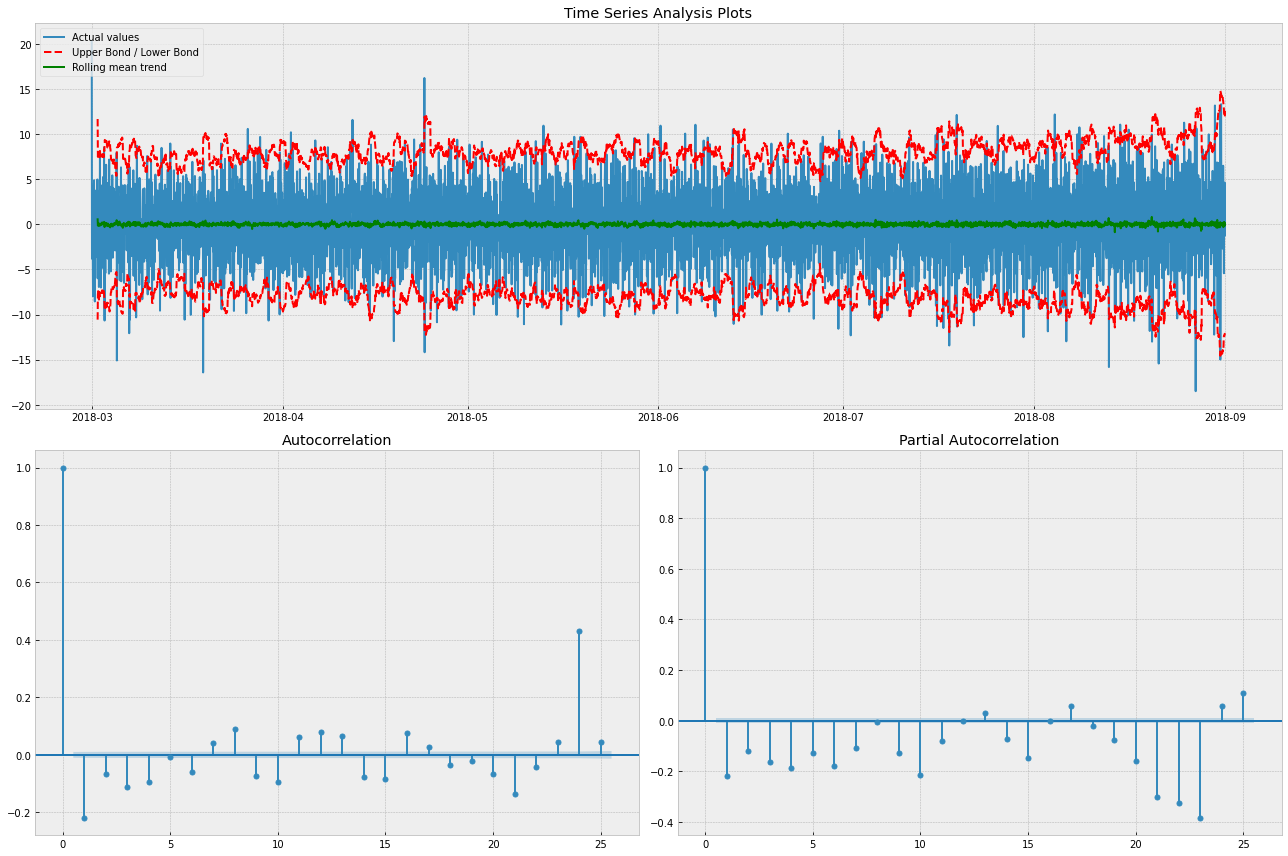

In [15]:
df_cox['num_orders_box_diff'] = df_cox['num_orders_box'] - df_cox['num_orders_box'].shift(1,fill_value=0)
tsplot(df_cox['num_orders_box_diff'],24, 0.05, lags=25)

# Prophet

In [16]:
df_prophet = df_cox.drop(['num_orders','num_orders_box_diff'],axis=1).reset_index()
df_prophet.columns = ['ds', 'y']
train_prophet, test_prophet = train_test_split(df_prophet, shuffle=False, test_size=0.1)
train_prophet = train_prophet.dropna()
test_prophet = test_prophet.dropna()
test_prophet_wo_y = test_prophet.drop(['y'],axis=1)

display(train_prophet)
display(test_prophet_wo_y)

,ds,y
0,2018-03-01 00:00:00,20.333680
1,2018-03-01 01:00:00,16.527351
2,2018-03-01 02:00:00,14.953441
3,2018-03-01 03:00:00,14.354605
4,2018-03-01 04:00:00,11.255387
...,...,...
3969,2018-08-13 09:00:00,21.465459
3970,2018-08-13 10:00:00,23.027570
3971,2018-08-13 11:00:00,22.052798
3972,2018-08-13 12:00:00,17.266081


,ds
3974,2018-08-13 14:00:00
3975,2018-08-13 15:00:00
3976,2018-08-13 16:00:00
3977,2018-08-13 17:00:00
3978,2018-08-13 18:00:00
...,...
4411,2018-08-31 19:00:00
4412,2018-08-31 20:00:00
4413,2018-08-31 21:00:00
4414,2018-08-31 22:00:00


In [17]:
m = Prophet()
m.fit(train_prophet)
forecast = m.predict(test_prophet_wo_y)
prophet_values = pd.DataFrame(forecast[['ds','yhat']]).set_index(test_prophet_wo_y.index)
display(prophet_values.head())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat
3974,2018-08-13 14:00:00,19.364199
3975,2018-08-13 15:00:00,21.189093
3976,2018-08-13 16:00:00,21.652230
3977,2018-08-13 17:00:00,20.399477
3978,2018-08-13 18:00:00,18.681016


In [18]:
test_prophet['y_reverse_boxcox'] = test_prophet.apply(lambda x: invboxcox(x['y'],lmbda),axis=1)
prophet_values['yhat_reverse_boxcox'] = prophet_values.apply(lambda x: invboxcox(x['yhat'],lmbda),axis=1)
print("RMSE Prophet:", mean_squared_error(test_prophet['y_reverse_boxcox'],prophet_values['yhat_reverse_boxcox'])**0.5)

RMSE Prophet: 47.78992937368532


# ML method


In [19]:
df_diff = make_features(df,'num_orders', 24, 24)
display(df_diff)
train_diff, test_diff = train_test_split(df_diff, shuffle=False, test_size=0.1)
train_diff = train_diff.dropna()
test_diff = test_diff.dropna()

train_diff_target = train_diff['num_orders']
train_diff_features = train_diff.drop('num_orders', axis=1)

test_diff_target = test_diff['num_orders']
test_diff_features = test_diff.drop('num_orders', axis=1)

,num_orders,year,month,day,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,0,207.0,217.0,197.0,116.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,2018,8,31,4,0,136.0,207.0,217.0,197.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,2018,8,31,4,0,154.0,136.0,207.0,217.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


### Regression


In [20]:
model_lin = LinearRegression()
model_lin.fit(train_diff_features,train_diff_target)
prediction_lin_train = model_lin.predict(train_diff_features)

print("RMSE train LinRegressor:", mean_squared_error(train_diff_target,prediction_lin_train)**0.5)

RMSE train LinRegressor: 25.79405094405123


### LGBoost

In [21]:
model_lgb = lgb.LGBMRegressor()
param_dist_lgb = {"learning_rate" : [0.05,0.1],
                  "num_leaves": [300,600,900],
                  "n_estimators": [100,200],
                  'max_depth': range(1,31,5)
                 }
grid_search_lgb = GridSearchCV(model_lgb,n_jobs=-1, param_grid=param_dist_lgb,
                               scoring=make_scorer(mean_squared_error,greater_is_better=False), verbose=5)
grid_search_lgb.fit(train_diff_features, train_diff_target)
grid_search_lgb.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=200, num_leaves=300)

In [22]:
model_lgb_final = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=300, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
model_lgb_final.fit(train_diff_features,train_diff_target)
predictions_lgb = model_lgb_final.predict(train_diff_features)
print("RMSE train LGBoost:", mean_squared_error(train_diff_target, predictions_lgb) ** 0.5)

RMSE train LGBoost: 14.020130137184632


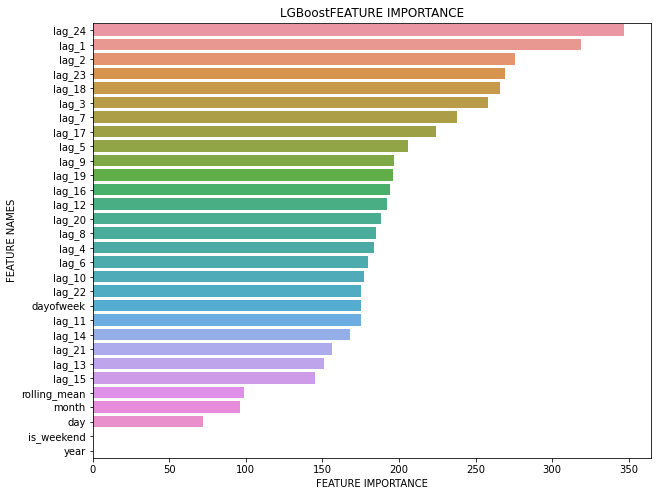

In [24]:
plot_feature_importance(model_lgb_final.feature_importances_,train_diff_features.columns,'LGBoost')

### CatBoost

In [25]:
model_cb = CatBoostRegressor()
model_cb_index = [0,1,2,3,4,5,6]
params_dist_cb = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'iterations': [100]}
grid_search_cb = GridSearchCV(model_cb, params_dist_cb, scoring=make_scorer(mean_squared_error,greater_is_better=False))
grid_search_cb.fit(train_diff_features, train_diff_target)
grid_search_cb.best_params_

15:	learn: 22.0166988	total: 622ms	remaining: 3.27s
16:	learn: 21.6750215	total: 662ms	remaining: 3.23s
17:	learn: 21.4042263	total: 701ms	remaining: 3.19s
18:	learn: 21.0623272	total: 740ms	remaining: 3.15s
19:	learn: 20.7894526	total: 782ms	remaining: 3.13s
20:	learn: 20.5938361	total: 821ms	remaining: 3.09s
21:	learn: 20.2232836	total: 864ms	remaining: 3.06s
22:	learn: 20.0365527	total: 904ms	remaining: 3.03s
23:	learn: 19.8872504	total: 946ms	remaining: 2.99s
24:	learn: 19.7649632	total: 986ms	remaining: 2.96s
25:	learn: 19.6532523	total: 1.03s	remaining: 2.92s
26:	learn: 19.5444226	total: 1.07s	remaining: 2.88s
27:	learn: 19.4525678	total: 1.11s	remaining: 2.86s
28:	learn: 19.2364091	total: 1.15s	remaining: 2.82s
29:	learn: 19.0196308	total: 1.19s	remaining: 2.79s
30:	learn: 18.8218057	total: 1.24s	remaining: 2.75s
31:	learn: 18.6405086	total: 1.28s	remaining: 2.71s
32:	learn: 18.5127953	total: 1.32s	remaining: 2.67s
33:	learn: 18.3258317	total: 1.36s	remaining: 2.63s
34:	learn: 1

{'depth': 7, 'iterations': 100, 'learning_rate': 0.15}

In [26]:
model_cb_final = CatBoostRegressor(depth = 7, iterations=100, learning_rate = 0.15)

In [27]:
model_cb_final.fit(train_diff_features,train_diff_target)
predictions_cb = model_cb_final.predict(train_diff_features)
print("RMSE train CatBoost:", mean_squared_error(train_diff_target, predictions_cb) ** 0.5)

0:	learn: 36.0482043	total: 3.6ms	remaining: 357ms
1:	learn: 33.8959899	total: 7.04ms	remaining: 345ms
2:	learn: 32.1068393	total: 9.84ms	remaining: 318ms
3:	learn: 30.7139597	total: 12.7ms	remaining: 305ms
4:	learn: 29.5290159	total: 15.3ms	remaining: 291ms
5:	learn: 28.5551337	total: 18ms	remaining: 283ms
6:	learn: 27.8368916	total: 20.8ms	remaining: 277ms
7:	learn: 27.2114524	total: 23.5ms	remaining: 270ms
8:	learn: 26.6767898	total: 26ms	remaining: 263ms
9:	learn: 26.2143684	total: 28.4ms	remaining: 255ms
10:	learn: 25.7725071	total: 30.9ms	remaining: 250ms
11:	learn: 25.3561301	total: 33.3ms	remaining: 244ms
12:	learn: 24.9204344	total: 35.7ms	remaining: 239ms
13:	learn: 24.5915657	total: 38.4ms	remaining: 236ms
14:	learn: 24.3547295	total: 40.9ms	remaining: 232ms
15:	learn: 24.1310008	total: 43.5ms	remaining: 228ms
16:	learn: 24.0135047	total: 46.6ms	remaining: 228ms
17:	learn: 23.8373245	total: 49.3ms	remaining: 224ms
18:	learn: 23.6947163	total: 52.7ms	remaining: 224ms
19:	lear

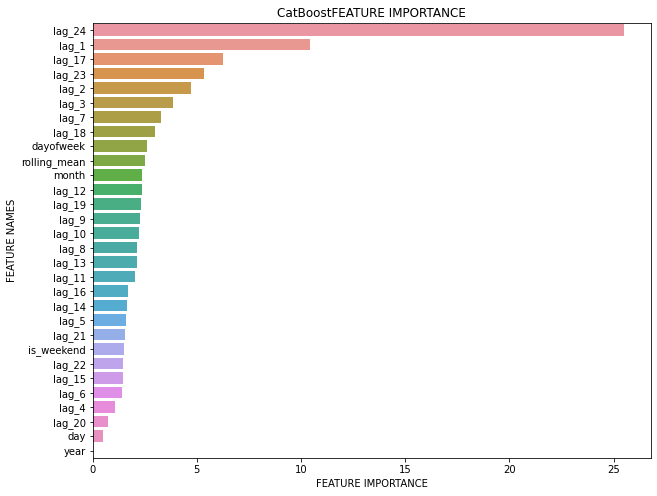

In [28]:
plot_feature_importance(model_cb_final.feature_importances_,train_diff_features.columns,'CatBoost')

# Neural Net

In [29]:
RANDOM_SEED = 123455

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [30]:
df_scaled = df.copy()
transformer = RobustScaler()
transformer = transformer.fit(df_scaled[['num_orders']])
df_scaled['num_orders'] = transformer.transform(df_scaled[['num_orders']])
train_LSTM, test_LSTM = train_test_split(df_scaled, shuffle=False, test_size=0.1)

In [31]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [32]:
TIME_STEPS = 24

trainX, trainY = create_dataset(train_LSTM, train_LSTM.num_orders, TIME_STEPS)
testX, testY = create_dataset(test_LSTM, test_LSTM.num_orders, TIME_STEPS)

print(testX.shape, testY.shape)

(418, 24, 1) (418,)


In [33]:
batch_size = 1
epochs = 70

model = Sequential()
model.add(LSTM(units=64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(10))
model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2)
#print(model.summary())

Epoch 1/70
3950/3950 - 10s - loss: 0.4343
Epoch 2/70
3950/3950 - 7s - loss: 0.4020
Epoch 3/70
3950/3950 - 8s - loss: 0.3942
Epoch 4/70
3950/3950 - 8s - loss: 0.3694
Epoch 5/70
3950/3950 - 7s - loss: 0.3470
Epoch 6/70
3950/3950 - 7s - loss: 0.3316
Epoch 7/70
3950/3950 - 8s - loss: 0.3259
Epoch 8/70
3950/3950 - 10s - loss: 0.3202
Epoch 9/70
3950/3950 - 10s - loss: 0.3213
Epoch 10/70
3950/3950 - 9s - loss: 0.3226
Epoch 11/70
3950/3950 - 7s - loss: 0.3167
Epoch 12/70
3950/3950 - 8s - loss: 0.3117
Epoch 13/70
3950/3950 - 10s - loss: 0.3168
Epoch 14/70
3950/3950 - 10s - loss: 0.3117
Epoch 15/70
3950/3950 - 10s - loss: 0.3143
Epoch 16/70
3950/3950 - 9s - loss: 0.3022
Epoch 17/70
3950/3950 - 9s - loss: 0.3057
Epoch 18/70
3950/3950 - 11s - loss: 0.2976
Epoch 19/70
3950/3950 - 11s - loss: 0.3027
Epoch 20/70
3950/3950 - 10s - loss: 0.3006
Epoch 21/70
3950/3950 - 10s - loss: 0.3029
Epoch 22/70
3950/3950 - 10s - loss: 0.3088
Epoch 23/70
3950/3950 - 10s - loss: 0.3005
Epoch 24/70
3950/3950 - 10s - l

In [34]:
predY = model.predict(testX)
predY_back = transformer.inverse_transform(predY)
testY_back = transformer.inverse_transform(testY.reshape(-1, 1))
print("RMSE neural net - LSTM:", mean_squared_error(testY_back,predY_back)**0.5)

RMSE neural net - LSTM: 51.341451387118084


# Test

While testing, we achieved lower RSME, it was not enough. We added 24 lags for daily pattern prediction. Overall CatBoost and Regression is optimal for this task. We tried to build a neuralnet, the perfomance was subpar, but we plan to tune it in the future.

In [35]:
predictions_lgb_test = model_lgb_final.predict(test_diff_features)
prediction_lin_test = model_lin.predict(test_diff_features)
predictions_cb_test = model_cb_final.predict(test_diff_features)
print("RMSE neural net - LSTM:", mean_squared_error(testY_back,predY_back)**0.5)
print("RMSE Prophet:", mean_squared_error(test_prophet['y_reverse_boxcox'],prophet_values['yhat_reverse_boxcox'])**0.5)
print("RMSE train LinRegressor:", mean_squared_error(test_diff_target,prediction_lin_test)**0.5)
print("RMSE train LGBoost:", mean_squared_error(test_diff_target,predictions_lgb_test)**0.5)
print("RMSE train CatBoost:", mean_squared_error(test_diff_target,predictions_cb_test)**0.5)

RMSE neural net - LSTM: 51.341451387118084
RMSE Prophet: 47.78992937368532
RMSE train LinRegressor: 45.14738020692439
RMSE train LGBoost: 42.10744055025079
RMSE train CatBoost: 42.74311555778122
